In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')
    
print(device)
device =  torch.device('cpu')

cpu


In [3]:
print(device)

cpu


In [4]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [5]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.467275,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.650008,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000271,0.000021,11.650008,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000278,0.000021,11.394500,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000185,0.000024,11.123803,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35370,21,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000282,0.000020,6.772435,6.773650,213,23,6.773650,6.773650,12.204,12.204
35371,22,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000191,0.000024,5.995879,5.996763,213,23,5.996763,5.996763,12.204,12.204
35372,23,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000102,0.000032,5.229508,5.230045,213,23,5.230045,5.230045,12.204,12.204
35373,24,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000013,0.000037,4.467800,4.468109,213,23,4.468109,4.468109,12.204,12.204


In [6]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [7]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [45]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'temp_heat00', 'diffusivity']
output_columns = ['temp_diff01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [46]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (21225, 15), X_test: (14150, 15)
y_train: (21225, 1), y_test: (14150, 1)


In [47]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [48]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

# layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

In [49]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [50]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=15, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [51]:
def implicit_diffusion(diff, temp, mean, std, mean2, std2):
    
    #mean = torch.tensor(mean).to(device)
    # std = torch.tensor(std).to(device)
    mean_diff = torch.tensor(mean[input_column_ix[13]]).to(device)
    std_diff = torch.tensor(std[input_column_ix[13]]).to(device)
    
    mean_temp = torch.tensor(mean[input_column_ix[14]]).to(device)
    std_temp = torch.tensor(std[input_column_ix[14]]).to(device)
    
    mean_out = torch.tensor(mean2).to(device)
    std_out = torch.tensor(std2).to(device)
    
    # de-normalise data
    diff = diff * std_diff + mean_diff
    print("diff:", diff)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    print("t:", t)
    
    dt = 3600 # model time step - fixed
    dx = 1 # model space step - fixed

    # OUTPUT FROM MLP
    d = diff #np.array([1e-5] * len(t)) # estimated diffusivity values

    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
    j = len(t)
    y = torch.zeros((len(t), len(t)), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * d    

    az = alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = -alpha # superdiagonal

    bz[0] = 1
    az[len(az)-2] = 0
    bz[len(bz)-1] = 1
    cz[0] = 0

    # tridiagonal matrix
    for k in range(j-1):
        y[k][k] = bz[k]
        y[k][k+1] = cz[k]
        y[k+1][k] = az[k]

    y[j-1, j-1] = 1

    mn = t * 0.0    
    mn[0] = t[0]
    mn[len(mn)-1] = t[len(t)-1]

    for k in range(1,j-1):
        mn[k] = alpha[k] * t[k-1] + 2 * (1 - alpha[k]) * t[k] + alpha[k] * t[k]

    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    print(y.dtype, mn.dtype)
    output = torch.linalg.solve(y, mn)
    
    proj = output
    

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.double)

    
    return proj

In [52]:
print(input_column_ix)
print(input_mean)
print(input_mean[input_column_ix[13]])
print(output_mean)
#print(torch.tensor(input_mean[input_column_ix][14]).to(device))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 14, 13]
[ 1.30000000e+01  1.93619387e+01  7.97611281e+02 -1.27637027e+02
 -1.68297160e+01  2.36993670e+02  4.08006076e-01  2.30560213e+00
  8.82174601e-03  3.60000000e+07  8.40535870e-04  1.72232038e+02
  1.14310954e+01  1.13445025e+01  2.07829505e-05]
2.0782950512289867e-05
[11.34604205]


In [53]:
diffusivity_true = torch.tensor(X_train[:,input_column_ix[13]], device=device).unsqueeze(1)
temp_heat_true = torch.tensor(X_train[:,input_column_ix[14]], device=device)#.unsqueeze(1)

In [54]:
mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)
print(mean_diff, std_diff)

tensor(2.0783e-05, dtype=torch.float64) tensor(1.0397e-05, dtype=torch.float64)


In [55]:
diffusivity_true*std_diff+mean_diff

tensor([[3.7190e-05],
        [3.7190e-05],
        [2.0770e-05],
        ...,
        [3.7190e-05],
        [3.7190e-05],
        [3.7190e-05]], dtype=torch.float64)

In [56]:
print(diffusivity_true[:25])
print(temp_heat_true[:25])
print(input_mean)
print(  input_std)
print( output_mean)
print( output_std)
print(y_train[:25])

tensor([[ 1.5781e+00],
        [ 1.5781e+00],
        [-1.2058e-03],
        [-2.3273e-02],
        [ 3.5734e-01],
        [ 7.7969e-01],
        [ 1.0179e+00],
        [ 8.0049e-01],
        [ 1.7388e-01],
        [-3.3551e-01],
        [-3.6113e-01],
        [-2.6854e-01],
        [-1.6469e-01],
        [-6.0495e-02],
        [ 5.7249e-02],
        [ 1.9935e-01],
        [ 3.7310e-01],
        [ 5.8682e-01],
        [ 8.5537e-01],
        [ 1.2092e+00],
        [ 1.5781e+00],
        [ 1.5781e+00],
        [ 1.5781e+00],
        [ 1.5781e+00],
        [ 1.5781e+00]], dtype=torch.float64)
tensor([ 0.0207,  0.0515,  0.0515,  0.0084, -0.0372, -0.0684, -0.0901, -0.1083,
        -0.1304, -0.1711, -0.2509, -0.3405, -0.4267, -0.5096, -0.5905, -0.6698,
        -0.7471, -0.8221, -0.8948, -0.9654, -1.0342, -1.1016, -1.1679, -1.2335,
        -1.2987], dtype=torch.float64)
[ 1.30000000e+01  1.93619387e+01  7.97611281e+02 -1.27637027e+02
 -1.68297160e+01  2.36993670e+02  4.08006076e-01  2.3056021

tensor([11.4673, 11.6279, 11.6406, 11.4030, 11.1391, 10.9514, 10.8187, 10.7069,
        10.5728, 10.3312,  9.8699,  9.3444,  8.8341,  8.3428,  7.8636,  7.3948,
         6.9379,  6.4946,  6.0652,  5.6489,  5.2430,  4.8422,  4.4356,  3.8262,
         4.1599], dtype=torch.float64)
tensor(5.9266, dtype=torch.float64)
tensor(11.3445, dtype=torch.float64)
[[11.46573   ]
 [11.62578297]
 [11.62984325]
 [11.39151521]
 [11.12939286]
 [10.9430975 ]
 [10.81100943]
 [10.69838842]
 [10.56141311]
 [10.31506644]
 [ 9.8522131 ]
 [ 9.32641078]
 [ 8.81571611]
 [ 8.32394415]
 [ 7.84407873]
 [ 7.3744882 ]
 [ 6.91672892]
 [ 6.47230774]
 [ 6.04144257]
 [ 5.62305876]
 [ 5.21512011]
 [ 4.81534681]
 [ 4.42201696]
 [ 4.03293311]
 [ 3.64629533]]


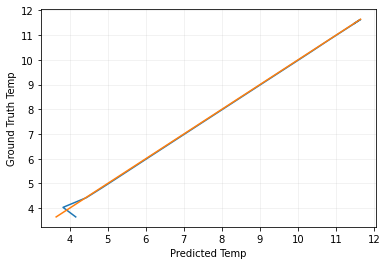

In [63]:
diff=diffusivity_true[:25]
temp=temp_heat_true[:25]
mean=input_mean
std=input_std
mean2=output_mean
std2=output_std

mean_diff = torch.tensor(mean[input_column_ix[13]]).to(device)
std_diff = torch.tensor(std[input_column_ix[13]]).to(device)

mean_temp = torch.tensor(mean[input_column_ix[14]]).to(device)
std_temp = torch.tensor(std[input_column_ix[14]]).to(device)

mean_out = torch.tensor(mean2).to(device)
std_out = torch.tensor(std2).to(device)

# de-normalise data
diff = diff * std_diff + mean_diff
# print("diff:", diff)

# INPUT DATA FROM PREVIOUS MODULE
t = temp * std_temp + mean_temp # temperature profile from previous module output
# print("t:", t)

dt = 3600 # model time step - fixed
dx = 1 # model space step - fixed

# OUTPUT FROM MLP
d = diff #np.array([1e-5] * len(t)) # estimated diffusivity values

# IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
j = len(t)
y = torch.zeros((len(t), len(t)), dtype=torch.float64).to(device)

alpha = (dt/dx**2) * d

az = - alpha # subdiagonal
bz = 2 * (1 + alpha) # diagonal
cz = - alpha # superdiagonal

bz[0] = 1
az[len(az)-2] = 0
bz[len(bz)-1] = 1
cz[0] = 0

az =  np.delete(az,0)
cz =  np.delete(cz,len(cz)-1)

# tridiagonal matrix
for k in range(j-1):
    y[k][k] = bz[k]
    y[k][k+1] = cz[k]
    y[k+1][k] = az[k]

y[j-1, j-1] = 1

# print(y[0:4])

mn = t * 0.0    
mn[0] = t[0]
mn[len(mn)-1] = t[len(t)-1]

for k in range(1,j-1):
    mn[k] = alpha[k] * t[k-1] + 2 * (1 - alpha[k]) * t[k] + alpha[k] * t[k]
# DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
# print(y.dtype, mn.dtype)

# print(y)
# print(mn)
output = torch.linalg.solve(y, mn)

proj = output
# print(proj)

# scaler = StandardScaler()
# scaler.fit(proj.reshape(-1, 1))
# scaler.fit(proj)

# normalise data back
#proj = scaler.transform(proj.reshape(-1, 1))
# proj = scaler.transform(proj)
mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
proj = (proj-mean_out)/std_out

proj = proj.to(torch.double)
print(proj * std_out + mean_out)
#print(proj * std_temp + mean_temp)
#print(y_train[:25] )
print(std_temp)
print(mean_temp)
print(y_train[:25] *5.9266 + 11.3445)

mod = proj * std_out + mean_out
obs = y_train[:25] *5.9266 + 11.3445

min_val = min(mod.numpy().min(), obs.min())
max_val = max(mod.numpy().max(), obs.max())
x = np.linspace(min_val, max_val, 100)

plt.figure()
plt.plot(mod.numpy(),obs, label="Predicted")
plt.plot(x,x, label="x=y line")
plt.grid("on", alpha=0.2)
plt.ylabel("Ground Truth Temp")
plt.xlabel("Predicted Temp")
#plt.legend(loc="bottom right")
plt.show()

In [22]:
pred = implicit_diffusion(diff=diffusivity_true[:25], 
                          temp=temp_heat_true[:25], 
                          mean=input_mean, 
                          std=input_std,
                          mean2=output_mean, 
                          std2=output_std)

diff: tensor([[3.7190e-05],
        [3.7190e-05],
        [2.0770e-05],
        [2.0541e-05],
        [2.4498e-05],
        [2.8890e-05],
        [3.1367e-05],
        [2.9106e-05],
        [2.2591e-05],
        [1.7295e-05],
        [1.7028e-05],
        [1.7991e-05],
        [1.9071e-05],
        [2.0154e-05],
        [2.1378e-05],
        [2.2856e-05],
        [2.4662e-05],
        [2.6884e-05],
        [2.9676e-05],
        [3.3355e-05],
        [3.7190e-05],
        [3.7190e-05],
        [3.7190e-05],
        [3.7190e-05],
        [3.7190e-05]], dtype=torch.float64)
t: tensor([11.4673, 11.6500, 11.6500, 11.3945, 11.1238, 10.9389, 10.8103, 10.7024,
        10.5719, 10.3305,  9.8574,  9.3268,  8.8159,  8.3246,  7.8447,  7.3750,
         6.9170,  6.4724,  6.0415,  5.6232,  5.2154,  4.8159,  4.4228,  4.0340,
         3.6476], dtype=torch.float64)
torch.float64 torch.float64


In [23]:
pred

tensor([ 0.0205, -0.1915, -0.1305, -0.1251, -0.1804, -0.2329, -0.2703, -0.2856,
        -0.2817, -0.2890, -0.3499, -0.4364, -0.5224, -0.6050, -0.6855, -0.7646,
        -0.8421, -0.9181, -0.9925, -1.0658, -1.1371, -1.2010, -1.2591, -1.3165,
        -1.2989], dtype=torch.float64)

In [24]:
y_train[:25]

array([[ 0.02045524],
       [ 0.0474611 ],
       [ 0.0481462 ],
       [ 0.00793292],
       [-0.0362952 ],
       [-0.06772897],
       [-0.09001629],
       [-0.10901893],
       [-0.13213088],
       [-0.17369716],
       [-0.25179477],
       [-0.34051382],
       [-0.42668375],
       [-0.50966083],
       [-0.5906289 ],
       [-0.66986329],
       [-0.74710139],
       [-0.82208893],
       [-0.89478916],
       [-0.9653834 ],
       [-1.03421521],
       [-1.10166929],
       [-1.16803615],
       [-1.23368658],
       [-1.29892429]])

In [34]:
print(std_out)
print(mean_out)
#std_out = std_out.numpy()
y_train[:25] = y_train[:25]*5.92675375 + 11.3460#std_out + mean_out
pred = pred * 5.92675375 + 11.3460
#pred = pred*torch.tensor(std_out) + torcmean_out
min_val = min(pred.numpy().min(), y_train[:25].min())
max_val = max(pred.numpy().max(), y_train[:25].max())
x = np.linspace(min_val, max_val, 100)

[5.92675375]
tensor([11.3460], dtype=torch.float64)


In [38]:
print(y_train[:25])
print(pred)

[[100696.35905346]
 [101866.82670456]
 [101896.51949739]
 [100153.62615621]
 [ 98236.72486342]
 [ 96874.34661754]
 [ 95908.38628603]
 [ 95084.78866737]
 [ 94083.08797434]
 [ 92281.55427754]
 [ 88896.70696738]
 [ 85051.51365993]
 [ 81316.80258113]
 [ 77720.47335693]
 [ 74211.21665812]
 [ 70777.10027212]
 [ 67429.50577674]
 [ 64179.45285646]
 [ 61028.53511735]
 [ 57968.89350454]
 [ 54985.637416  ]
 [ 52062.09459311]
 [ 49185.67261981]
 [ 46340.30177144]
 [ 43512.81894397]]
tensor([79.3095, 71.8627, 74.0058, 74.1959, 72.2536, 70.4093, 69.0963, 68.5587,
        68.6945, 68.4408, 66.2993, 63.2616, 60.2400, 57.3395, 54.5126, 51.7350,
        49.0094, 46.3417, 43.7278, 41.1523, 38.6502, 36.4046, 34.3616, 32.3485,
        32.9644], dtype=torch.float64)


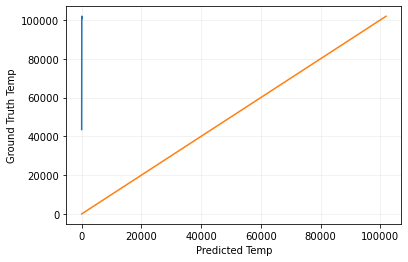

In [37]:
plt.figure()
plt.plot(pred.numpy(),y_train[:25], label="Predicted")
plt.plot(x,x, label="x=y line")
plt.grid("on", alpha=0.2)
plt.ylabel("Ground Truth Temp")
plt.xlabel("Predicted Temp")
#plt.legend(loc="bottom right")
plt.show()

In [ ]:
print(temp_heat_true[:25])

In [ ]:
# # test if the Crank-Nicholson scheme works

# temp = torch.rand(5,1).to(device)
# diff = torch.rand(5,1).to(device)
# print(temp), print(diff)
# implicit_diffusion(diff, temp, input_mean, input_std,
#                                  output_mean, output_std)

In [ ]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        
        # get temperature input
        temp_input = x[:,13]
        #print(temp_input)
        
        
        optimizer.zero_grad()
        #print(model(x))
        proj = model(x)
        #print(proj)
        
        # torch.set_printoptions(profile="full")
        
        pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)

        # print(pred)
        # print(y)
        
        #pred.grad.data.copy_(proj.grad.data)
        
        # proj[0:30,0] = pred
        
        # print(proj)
        
        #print(pred)
        #print(y)
        
        pred = pred.to(dtype=torch.float32)
        
        loss = criterion(pred, y)
        #print(loss)
        #loss= loss.double
        #print(loss)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            #pred = model(x)
            
            #mean=0.0
            #std=1.0
            #mean = torch.tensor(mean).to(device)
            #std = torch.tensor(std).to(device)
            temp_input = x[:,13] #* std + mean

            optimizer.zero_grad()
            proj = model(x)

            pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)

            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [ ]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        
        temp_input = x[:,13]
        proj = model(x)
        pred = implicit_diffusion(proj, temp_input, input_mean, input_std,
                                 output_mean, output_std)        
        pred = pred.to(dtype=torch.float32)
        
        
        y = y * std + mean
        pred = pred * std + mean
        
        #red = torch.squeeze(pred)
        
        #rint(pred.shape)
        
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    
    rmse_temp = rmse(y_[:,0], pred_)
    
    l2_error_temp = l2_error(y_[:,0], pred_)
    return rmse_temp, l2_error_temp

In [ ]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

In [ ]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

# Saving Model

In [ ]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
output_mean